In [1]:
import sys
sys.version

'3.8.10 (default, Jun 22 2022, 20:18:18) \n[GCC 9.4.0]'

In [2]:
# %pip install pandas nltk matplotlib seaborn

In [3]:
import numpy as np
import pandas as pd

In [44]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
train_data = pd.read_csv("data/sentiment_analysis/twitter_training.csv", header=None)
valid_data = pd.read_csv("data/sentiment_analysis/twitter_validation.csv", header=None)

train_data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
# Add identifiable column names to the data
column_names = ["id", "entity", "sentiment", "content"]
train_data.columns = column_names
valid_data.columns = column_names

train_data.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
# Constant for target column name
TARGET = "sentiment"

# Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

### general info

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 non-null  int64 
 1   entity     73996 non-null  object
 2   sentiment  73996 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### check for nan values

In [18]:
train_data.isnull().sum()

id           0
entity       0
sentiment    0
content      0
dtype: int64

In [19]:
valid_data.isnull().sum()

id           0
entity       0
sentiment    0
content      0
dtype: int64

The good news is there is no "invalid" sample in the validation data. And the bad news is we get 686 "invalid" samples in the train data.

In [16]:
# drop samples with nans
train_data.dropna(inplace=True, axis=0)

### Tweet statistics

In [32]:
tweets = train_data.content

In [35]:
tweet_lens = np.array([len(t.split()) for t in tweets.values])
len_mean = np.mean(tweet_lens)
len_mean

19.226620357857183

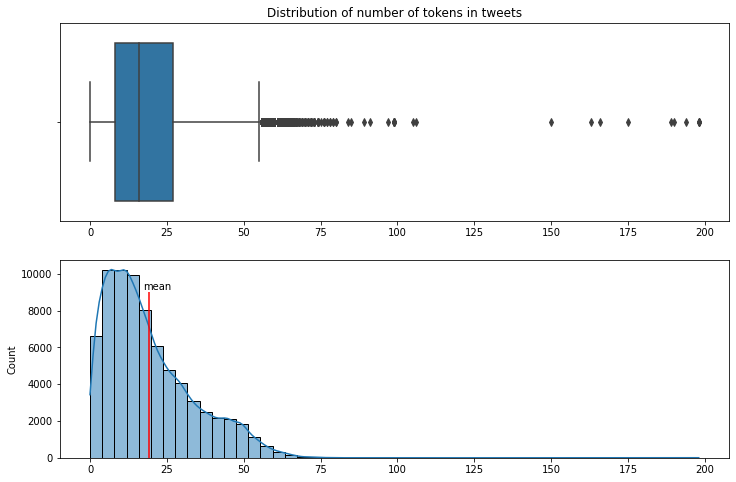

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title('Distribution of number of tokens in tweets') # token can be words, punctuation, whatever single text
sns.boxplot(x=tweet_lens, ax=axes[0])
sns.histplot(x=tweet_lens, bins=50, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 9000, color = 'r')
plt.annotate("mean", xy=(len_mean, 9000), xytext=(len_mean-2, 9150),
            color='k')
plt.show()

We observe some outliers which drive the mean towards 20 tokens, even though the majority of the tweets have less than 20 tokens. It can be good to look at those outliers before proceeding !

In [38]:
# Most of the outliers have a number of tokens superior than 75. 
# How to choose the cutoff is a matter of trials and error.
# We can maybe have two groups of outliers: ones with more than 150 tokens 
# and others with less than 150 tokens and more than 75 tokens
outliers_group1 = train_data.content[tweet_lens >= 150]
outliers_group2 = train_data.content[(75 <= tweet_lens) & (tweet_lens < 150)]

In [39]:
print(f"Number of 'extreme outliers': {len(outliers_group1)}")
print(f"Number of 'other outliers':   {len(outliers_group2)}")

Number of 'extreme outliers': 11
Number of 'other outliers':   28


Overall we observe there is not much of the outliers. They account for 39 samples which is about 0.05 % of all training data

In [50]:
# let's see some of these tweets
outliers_group1.sample(3, random_state=42)

52136    There was a meeting with the interns on their upcoming projects, and my background was a TV showing my ped Red Dead Reduction 2 after the pillaging of the dead body, so I'm just trying to hide it from everyone, as I am: / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / /
1826                                                                                                                           _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

In [51]:
outliers_group2.sample(3, random_state=42)

20494                                                                                                                                                                                                                                                                                                                                                      Or Jacii : You got it! Great job 10 / 10.. Jaci : is probably the more easily appropriate word spelling but no result 8 / 10.. Jacci : wrong double letter but good effort 6 / 10.. Jaccii : i don wanna ’ t... that ’ s no 4 / 10.. Jacqui : like what? No stop 0 / 5 10.. Jaccciii : are you trolling me or because have I done something awkward again? 10 / 10
64210                                                                                                                                                                                                                                                                                                   of

#### For outliers, mots of the tweets either have lots of punctuation/special marks (e.g.; - or /) or repeated tokens (e.g.; Italy or aa)

### Tweet categories statistics

In [52]:
# balance
target_balance = train_data[TARGET].value_counts()
target_balance

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: sentiment, dtype: int64

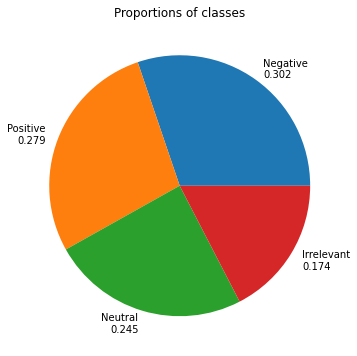

In [56]:
plt.figure(figsize=(8, 6))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(train_data), 3)}' 
                                for idx in target_balance.index], 
       )
plt.title('Proportions of classes')
plt.show()

#### Tweets have almost same proportion of sentiment accross the 3 categories of interest (positive, negative and neutral)

In [59]:
# import nltk
# nltk.download('stopwords')

In [67]:
# top words
import re
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

word_counts = {
    'Positive': [],
    'Neutral': [],
    'Irrelevant': [],
    'Negative': []
}

pattern = re.compile('[^\w ]') # \w matches any alphanumeric character
for text, t in zip(train_data['content'], train_data[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

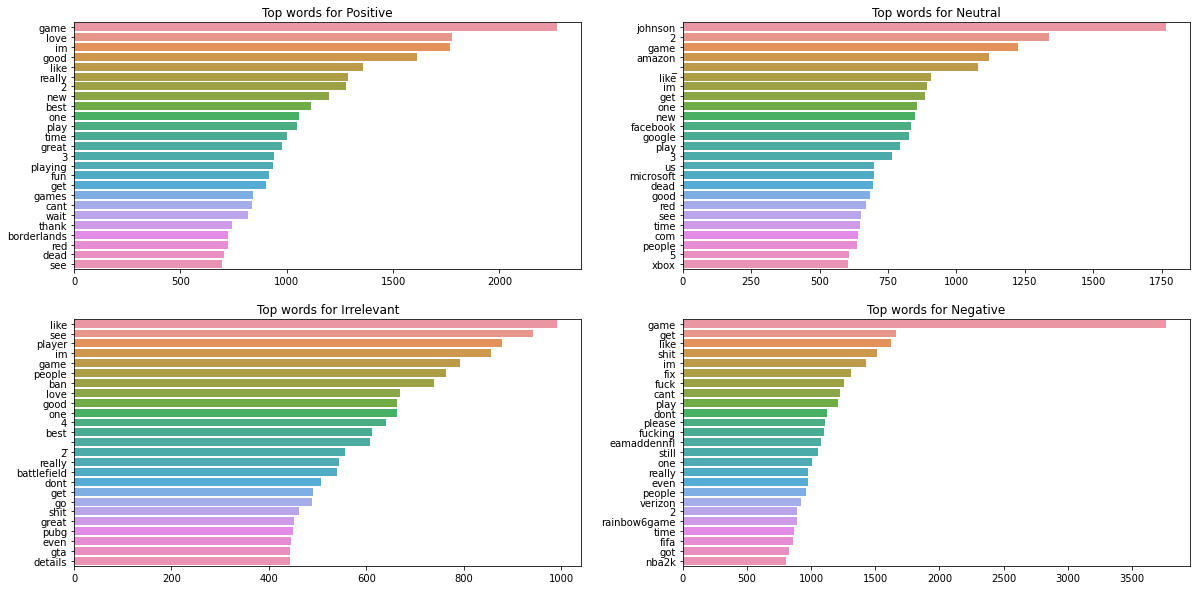

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

#### We can observe that top words are different accross the different categories, with positive words like good, like, best, great coming in the positive category tweets, and shit, fuck, fucking coming in the negative category tweets.

#### We can look at some correlation between words to have an idea of words which are most correlated

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english',
                        max_features=10000)


features = tfidf.fit_transform(train_data.content).toarray()

labels = train_data[TARGET]

In [70]:
from sklearn.feature_selection import chi2

N = 10
for label in set(labels):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Neutral:
  * Most Correlated Unigrams are: tt, dlvr, 2020, check, com, amazon, achievement, earned, https, johnson
  * Most Correlated Bigrams are: twitch tv, johnson stop, stop selling, ift tt, watch video, check video, johnson johnson, chance win, com 2020, just earned

==> Positive:
  * Most Correlated Unigrams are: good, amazing, thank, creed, nice, excited, fun, wow, wait, love
  * Most Correlated Bigrams are: feels good, bf4db com, player ban, looking forward, com player, best game, wait play, creed odyssey, assassins creed, assassin creed

==> Negative:
  * Most Correlated Unigrams are: sucks, love, shit, rainbow6game, wtf, servers, nba2k, fuck, eamaddennfl, fix
  * Most Correlated Bigrams are: details bf4db, red dead, bf4db com, player ban, com player, fix servers, eamaddennfl fix, rainbow6game fix, fix game, twitch tv

==> Irrelevant:
  * Most Correlated Unigrams are: battlefield, montage, eamaddennfl, verizon, johnson, details, occurred, ban, bf4db, player
  * Most Corre

In [71]:
# len for classes without outliers
pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) 
                           for text in train_data.content if len(text) < 125], columns=['len'])

In [73]:
tweets_len['target'] = train_data[TARGET]
tweets_len.head()

,len,target
0,10,Positive
1,12,Positive
2,10,Positive
3,10,Positive
4,12,Positive


In [74]:
tweets_len.groupby('target').mean()

,len
target,
Irrelevant,10.251140
Negative,10.328170
Neutral,10.298915
Positive,10.431315


In [75]:
tweets_len.groupby('target').max()

,len
target,
Irrelevant,27
Negative,29
Neutral,27
Positive,34


In [76]:
tweets_len.groupby('target').min()

,len
target,
Irrelevant,0
Negative,0
Neutral,0
Positive,0


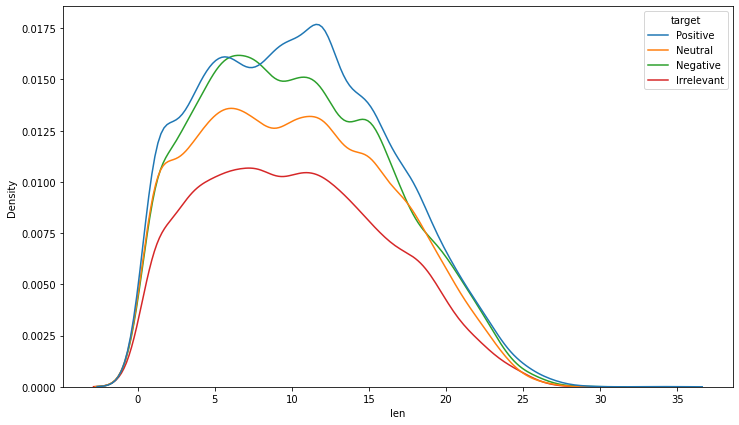

In [77]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=tweets_len, x='len', hue='target')
plt.show()

In [79]:
# capitalization distribution
capitalized = [np.sum([t.isupper() for t in text.split()]) 
               for text in np.array(train_data.content)]

In [80]:
capitalized_target = pd.DataFrame([(c, t) for c, t in zip(capitalized, train_data[TARGET])], 
                                  columns=['capital', 'target'])

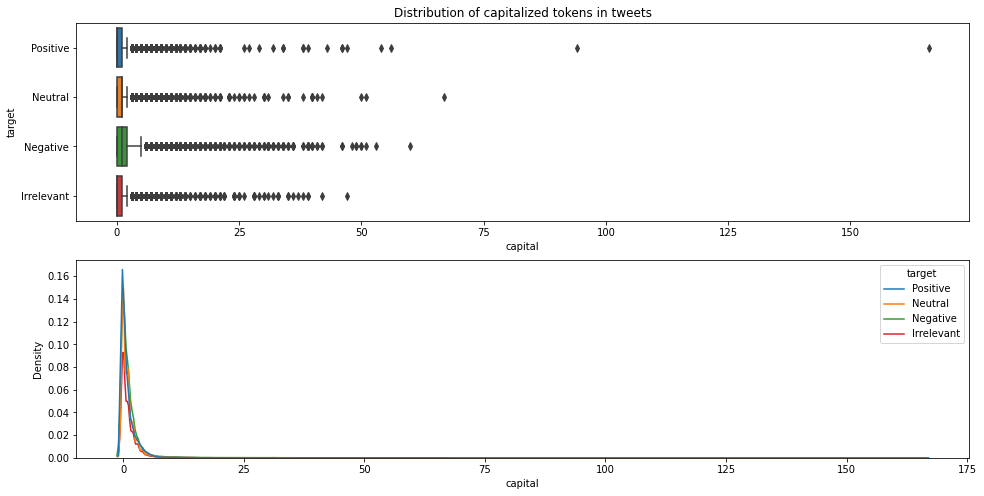

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
axes[0].set_title('Distribution of capitalized tokens in tweets')
sns.boxplot(x=capitalized_target['capital'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target, x='capital', hue='target', ax=axes[1])
plt.show()

Text(0.5, 1.0, 'Frequencies of meeting referred objects in each category')

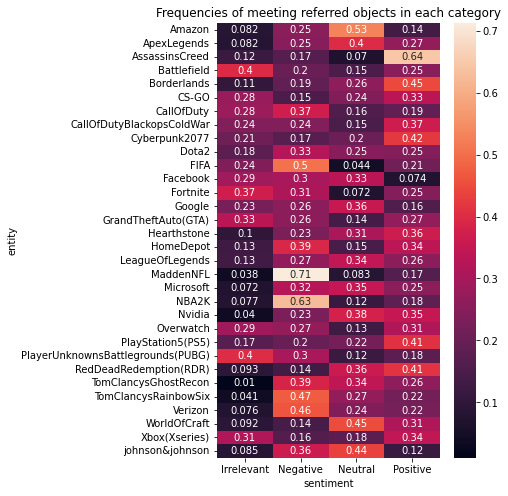

In [82]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.crosstab(train_data.entity, train_data[TARGET], normalize='index'), annot=True)
plt.title('Frequencies of meeting referred objects in each category')